/home/wagner/miniconda3/envs/xai4ecg/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


load model..
all parameters have same shape


100%|██████████████████████████████████████████████████████████████████| 171/171 [00:01<00:00, 110.03it/s]


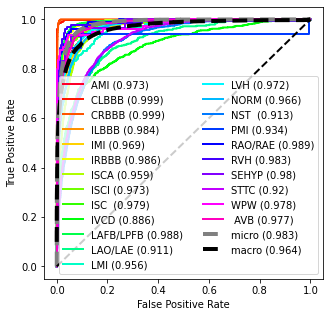

In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
import os
import sys
module_path = os.path.abspath(os.path.join('../code'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np
import utils
import torch 
from tqdm import tqdm

task='subdiagnostic'
modeltype='lenet'

signals,df,labels,model=utils.get_dataset_label_model(task=task, modeltype=modeltype)
df['subdiagnostic'] = df['subdiagnostic'].apply(lambda x: eval(x))
df['diagnostic'] = df['diagnostic'].apply(lambda x: eval(x))
df.sex = df.sex.apply(lambda x: 'male' if x==0 else 'female')

predictions = utils.predict_samples(model, signals)
aucs = utils.multiclass_roc_curve(labels, predictions, utils.label_mappings[task])

100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 67.20it/s]


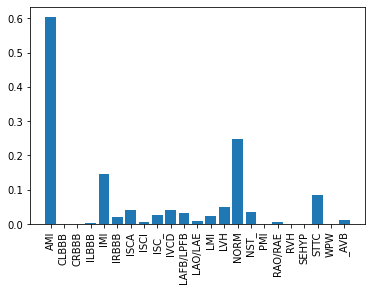

In [2]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import roc_auc_score, accuracy_score, adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
import copy
import attribute_signals as attr
from torch import nn

def do_clustering(representation, true_labels, cluster_model_type, n_clusters=2, whiten=True, n_init=1, do_pca=True, n_components=12):
    x = copy.copy(representation.reshape((len(representation), np.prod(representation.shape[1:]))))
    
    if do_pca:
        pca = PCA(n_components=n_components, whiten=whiten)
        x = pca.fit_transform(x)
        #real_c = np.argwhere(np.cumsum(pca.explained_variance_ratio_)>=.75).flatten()[0]
        #x = x[:,:real_c]
        
    if cluster_model_type == 'kmeans':
        clustering_model = KMeans(n_clusters=n_clusters, n_init=n_init)
    elif cluster_model_type == 'gmm':
        clustering_model = GMM(n_components=n_clusters, n_init=n_init, covariance_type='full', tol=.0001, warm_start=True)
        
    clustering = clustering_model.fit_predict(x)
        
    ars = adjusted_rand_score(encoded_tmp_labels, clustering)
    acc = max([
        accuracy_score(true_labels, clustering),
        accuracy_score(true_labels, 1-clustering)])
    
    return clustering, ars, acc, clustering_model, pca#, real_c

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def get_median_beats(signals, df, t_before=30, t_after=50, only_beats=True):
    median_beats = []
    n = signals.shape[1]
    for i, signal in enumerate(signals):
        row = df.iloc[i]
        rpeaks = np.array(row.r_peaks).astype(int)
        beats = np.array([signal[ri-t_before:ri+t_after,:] for ri in rpeaks if (ri<n-t_after)&(ri > t_before)])
        median_beats.append(np.mean(beats,axis=0))  
    return np.array(median_beats)

mask = df.diagnostic.apply(lambda x: (('ASMI' in x))&(len(x)==1))

if modeltype == 'lenet':
    batch_size=64
    features = []
    for i in tqdm(range(len(signals[mask])//batch_size + 1)):
        yi = model.sequential[:-2].forward(torch.from_numpy(np.swapaxes(signals[mask][i*batch_size:(i+1)*batch_size],1,2)).type(torch.float).to('cuda')).cpu().detach().numpy()
        features.append(yi)
    features = np.concatenate(features)
else:
    feature_extractor = nn.Sequential(*list(model.model.children())[:-1])
    batch_size=32
    features = []
    for i in tqdm(range(len(signals[mask])//batch_size + 1)):
        yi = feature_extractor.forward(torch.from_numpy(np.swapaxes(signals[mask][i*batch_size:(i+1)*batch_size],1,2)).type(torch.float).to('cuda')).cpu().detach().numpy()
        features.append(yi)
    features = np.concatenate(features)

cidxs = predictions[mask].argmax(axis=-1)
method = 'gradient'
relevance = attr.attribute_signals(model, signals[mask], cidxs, labels.shape[-1], modeltype, method, batch_size=16)
heats = get_median_beats(relevance, df[mask])
beats = get_median_beats(signals[mask], df[mask])
unique_labels = np.array(df[mask].sex)

plt.bar(range(predictions.shape[-1]), np.mean(sigmoid(predictions[mask]),axis=0))
plt.xticks(range(predictions.shape[-1]),utils.label_mappings[task], rotation=90)
plt.show()

gradient_heats


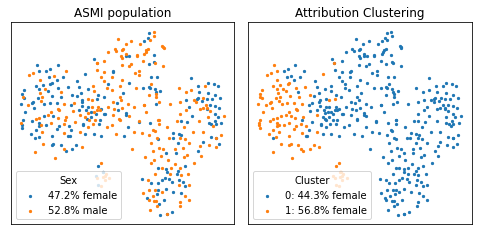

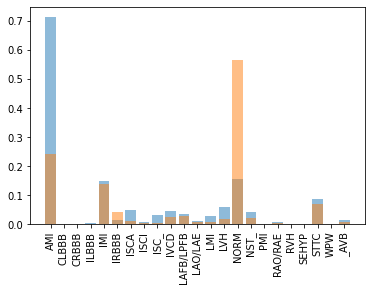

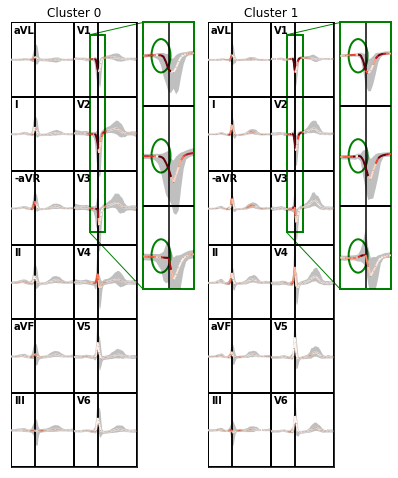

In [3]:
tsne_model_attr = TSNE()
embedding_attr = tsne_model_attr.fit_transform(heats.reshape((len(heats), np.prod(heats.shape[1:]))))

hyperparameters = {

    'gradient_heats':{
        'title':'Attribution',
        'x':heats,
        'z':embedding_attr,
        'cluster_method':'gmm',
        'do_pca':True,
        'n_components':6,
        'whiten':True,
        'n_init':10
    }
}

counts1 = df[mask].sex.value_counts().loc[['male','female']]

scale=1.125
le = LabelEncoder()
encoded_tmp_labels = le.fit_transform(unique_labels)
pca_models = []
for i, (key, param_dic) in enumerate(hyperparameters.items()):
    print(key)
    if key in ['gradient_heats']:#,'features','gradient_heats']:#['input', 'features', 'gradient_heats']:
        clustering, ars, acc, cluster_model, pca_model = do_clustering(
            param_dic['x'], 
            encoded_tmp_labels, 
            param_dic['cluster_method'], 
            n_components=param_dic['n_components'], 
            do_pca=param_dic['do_pca'], 
            whiten=param_dic['whiten'],
            n_init=param_dic['n_init'])
        pca_models.append(pca_model)
        fig, axarr = plt.subplots(1,2, figsize=(6*scale,3*scale))

        if True:
            for labeli in np.unique(unique_labels):
                sel = param_dic['z'][unique_labels == labeli]
                perc = (counts1[labeli]/(counts1.values.sum()))*100
                axarr[0].scatter(sel[:,0], sel[:,1], label=str(np.round(perc,1))+'% '+labeli,s=5,alpha=1.)
        else:
            axarr[0].scatter(param_dic['z'][:,0], param_dic['z'][:,1], c=df[mask].sex,s=5,alpha=1., cmap='bwr')

        for labeli in np.unique(clustering):
            sel = param_dic['z'][clustering == labeli]
            countsi = df[mask][clustering == labeli].sex.value_counts().loc[['male','female']]
            perc = (countsi['female']/(countsi.values.sum()))*100
            axarr[1].scatter(sel[:,0], sel[:,1],s=5,alpha=1., label=str(labeli)+': '+str(np.round(perc,1))+'% female')

        axarr[0].legend(title='Sex')
        axarr[1].legend(title='Cluster')
        axarr[0].set_title('ASMI population')
        #axarr[1].set_title('Clustering')
        axarr[0].set_xticks([])
        axarr[0].set_yticks([])
        axarr[1].set_xticks([])
        axarr[1].set_yticks([])
        axarr[1].set_title('Attribution Clustering')
        plt.tight_layout()
        plt.savefig('embedding_ASMIs_'+param_dic['title']+'_'+modeltype+'.png', bbox_inches='tight', pad_inches=.1, dpi=300)
        plt.savefig('embedding_ASMIs_'+param_dic['title']+'_'+modeltype+'.pdf', bbox_inches='tight', pad_inches=.1)
        plt.show()
        break

from matplotlib.colors import ListedColormap, Normalize
from matplotlib.collections import LineCollection
import plot_utils as pu

if param_dic['cluster_method'] == 'gmm':
    mean_attributions = pca_model.inverse_transform(cluster_model.means_).reshape((2,80,12))
else:
    mean_attributions = pca_model.inverse_transform(cluster_model.cluster_centers_).reshape((2,80,12))

mean_inputs = np.array([np.median(beats[clustering == labeli], axis=0) for labeli in np.unique(clustering)])
mean_lower = np.array([np.quantile(beats[clustering == labeli], axis=0, q=.05) for labeli in np.unique(clustering)])
mean_upper = np.array([np.quantile(beats[clustering == labeli], axis=0, q=.95) for labeli in np.unique(clustering)])

sub_preds = predictions[mask]
for labeli in np.unique(clustering):
    sub = sub_preds[clustering == labeli]
    plt.bar(range(predictions.shape[-1]), np.mean(sigmoid(sub),axis=0), label="cluster " +str(labeli),alpha=.5)
plt.xticks(range(predictions.shape[-1]),utils.label_mappings[task], rotation=90)
plt.show()

from matplotlib.patches import Ellipse

scale=1.125
offset=3
fig, axarr = plt.subplots(1,2, figsize=(5*scale,6*scale))#, sharex=True, sharey=True)
plt.subplots_adjust(wspace=.5)
for i,j in [(0,0),(1,1)]:
    if i != 2:
        pu.plot_beat(
                mean_inputs[i],
                axarr[j],
                '',
                lower=mean_lower[i], 
                upper=mean_upper[i], 
                offset=offset, annotate=True, border=True, lw=1
            )
        pu.plot_heat(
                mean_inputs[i],
                abs(mean_attributions[i]),
                axarr[j],
                '',
                offset=offset, annotate=False, border=False
            )
        axarr[i].set_xticks([])
        axarr[i].set_yticks([])
        axarr[j].set_title('Cluster '+str(i))
        axarr[i].axvline(30,c='k')
        axarr[i].axvline(30+80,c='k')
        axarr[i].axvline(30,c='k')
        axarr[j].axvline(30+80,c='k')
        if True:
            # inset axes....
            axins = axarr[j].inset_axes([1.05, .4, 0.4, 0.6])

            pu.plot_beat(
                    mean_inputs[i],
                    axins,
                    '',
                    lower=mean_lower[i], 
                    upper=mean_upper[i], 
                    offset=offset, annotate=False, border=True, lw=1
                )
            pu.plot_heat(
                    mean_inputs[i],
                    abs(mean_attributions[i]),
                    axins,
                    '',
                    offset=offset, annotate=False, border=False
                )


            # sub region of the original image
            x1, x2, y1, y2 = 100,120,-7.,1
            axins.set_xlim(x1, x2)
            axins.set_ylim(y1, y2)
            axins.set_xticks([])
            axins.set_yticks([])
            axins.axvline(30,c='k')
            axins.axvline(30+80,c='k')
            #axins.set_facecolor((1.0, 0.47, 0.42))
            axarr[j].indicate_inset_zoom(axins, edgecolor="green",lw=2,alpha=1,zorder=1)
            axins.spines['bottom'].set_color('g')
            axins.spines['top'].set_color('g') 
            axins.spines['right'].set_color('g')
            axins.spines['left'].set_color('g')
            axins.spines['bottom'].set_linewidth(2)
            axins.spines['top'].set_linewidth(2)
            axins.spines['right'].set_linewidth(2)
            axins.spines['left'].set_linewidth(2)

            for yi in [0,-offset, -2*offset]:
                e =  Ellipse(xy=[107,yi],
                    width=7.5, height=1,
                    angle=0, fill=False, lw=2, color='g')
                axins.add_artist(e)
plt.tight_layout()
plt.show()

# Sanity Check
Perform experiment from confirmative example on subdiagnostic model and see that features are best.

100%|█████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 17.46it/s]


input


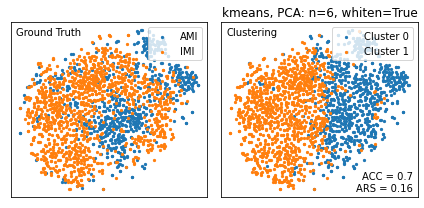

features


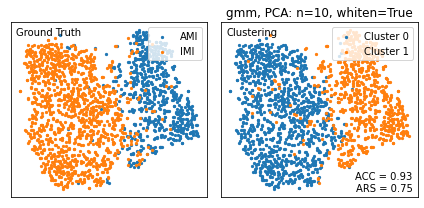

gradient_heats


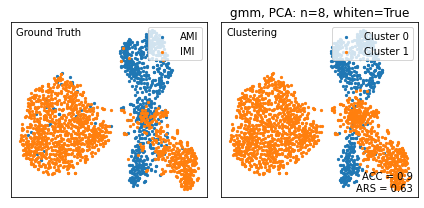

In [4]:
import attribute_signals as attr
from torch import nn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import roc_auc_score, accuracy_score, adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
import copy

def do_clustering(representation, true_labels, cluster_model_type, n_clusters=2, whiten=True, n_init=1, do_pca=True, n_components=12):
    x = copy.copy(representation.reshape((len(representation), np.prod(representation.shape[1:]))))
    
    if do_pca:
        pca = PCA(n_components=n_components, whiten=whiten)
        x = pca.fit_transform(x)
    if cluster_model_type == 'kmeans':
        clustering_model = KMeans(n_clusters=n_clusters, n_init=n_init)
    elif cluster_model_type == 'gmm':
        clustering_model = GMM(n_components=n_clusters, n_init=n_init)#, covariance_type='full', tol=.0001, warm_start=True)
        
    clustering = clustering_model.fit_predict(x)
        
    ars = adjusted_rand_score(encoded_tmp_labels, clustering)
    acc = max([
        accuracy_score(true_labels, clustering),
        accuracy_score(true_labels, 1-clustering)])
    
    return clustering, ars, acc, clustering_model, pca

def get_median_beats(signals, df, t_before=30, t_after=50, only_beats=True):
    median_beats = []
    n = signals.shape[1]
    for i, signal in enumerate(signals):
        row = df.iloc[i]
        rpeaks = np.array(row.r_peaks).astype(int)
        beats = np.array([signal[ri-t_before:ri+t_after,:] for ri in rpeaks if (ri<n-t_after)&(ri > t_before)])
        median_beats.append(np.mean(beats,axis=0))  
    return np.array(median_beats)

mask = df.subdiagnostic.apply(lambda x: (('AMI' in x)|('IMI' in x))&(len(x)==1))

if modeltype == 'lenet':
    batch_size=64
    features = []
    for i in tqdm(range(len(signals[mask])//batch_size + 1)):
        yi = model.sequential[:-2].forward(torch.from_numpy(np.swapaxes(signals[mask][i*batch_size:(i+1)*batch_size],1,2)).type(torch.float).to('cuda')).cpu().detach().numpy()
        features.append(yi)
    features = np.concatenate(features)
else:
    feature_extractor = nn.Sequential(*list(model.model.children())[:-3])
    batch_size=32
    features = []
    for i in tqdm(range(len(signals[mask])//batch_size + 1)):
        yi = feature_extractor.forward(torch.from_numpy(np.swapaxes(signals[mask][i*batch_size:(i+1)*batch_size],1,2)).type(torch.float).to('cuda')).cpu().detach().numpy()
        features.append(yi)
    features = np.concatenate(features)
    
cidxs = predictions[mask].argmax(axis=-1)
method = 'gradient'
relevance = attr.attribute_signals(model, signals[mask], cidxs, labels.shape[-1], modeltype, method, batch_size=16)
heats = get_median_beats(relevance, df[mask])
beats = get_median_beats(signals[mask], df[mask])
unique_labels = df[mask].subdiagnostic.apply(lambda x: x[0])




if True:
    tsne_model_input = TSNE()
    embedding_input = tsne_model_input.fit_transform(beats.reshape((len(beats), np.prod(beats.shape[1:]))))

    tsne_model_feature = TSNE()
    embedding_feature = tsne_model_feature.fit_transform(features.reshape((len(features), np.prod(features.shape[1:]))))

    tsne_model_attr = TSNE()
    embedding_attr = tsne_model_attr.fit_transform(heats.reshape((len(heats), np.prod(heats.shape[1:]))))

hyperparameters = {
    'input':{
        'title':'Input',
        'x':beats,
        'z':embedding_input,
        'cluster_method':'kmeans',
        'do_pca':True,
        'n_components':6,
        'whiten':True,
        'n_init':10
    },
    'features':{
        'title':'Hidden Features',
        'x':features,
        'z':embedding_feature,
        'cluster_method':'gmm',
        'do_pca':True,
        'n_components':10,
        'whiten':True,
        'n_init':10
    },
    'gradient_heats':{
        'title':'Attribution',
        'x':heats,
        'z':embedding_attr,
        'cluster_method':'gmm',
        'do_pca':True,
        'n_components':8,
        'whiten':True,
        'n_init':10
    }
}

le = LabelEncoder()
encoded_tmp_labels = le.fit_transform(unique_labels)
pca_models = []
for i, (key, param_dic) in enumerate(hyperparameters.items()):
    print(key)
    if key in ['input', 'features', 'gradient_heats']:
        clustering, ars, acc, cluster_model, pca_model = do_clustering(
            param_dic['x'], 
            encoded_tmp_labels, 
            param_dic['cluster_method'], 
            n_components=param_dic['n_components'], 
            do_pca=param_dic['do_pca'], 
            whiten=param_dic['whiten'],
            n_init=param_dic['n_init'])
        pca_models.append(pca_model)
        fig, axarr = plt.subplots(1,2, figsize=(6,3))

        for labeli in np.unique(unique_labels):
            sel = param_dic['z'][unique_labels == labeli]
            axarr[0].scatter(sel[:,0], sel[:,1], label=labeli,s=5,alpha=1.)

        for labeli in np.unique(clustering):
            sel = param_dic['z'][clustering == labeli]
            axarr[1].scatter(sel[:,0], sel[:,1],s=5,alpha=1., label="Cluster " + str(labeli))

        axarr[1].text(.975,.025,'ACC = '+str(np.round(acc,2))+'\nARS = '+str(np.round(ars,2)), ha='right', va='bottom',transform=axarr[1].transAxes)
        axarr[0].text(.025,.975,'Ground Truth', ha='left', va='top',transform=axarr[0].transAxes)
        axarr[1].text(.025,.975,'Clustering', ha='left', va='top',transform=axarr[1].transAxes)

        axarr[0].legend(loc='upper right')
        axarr[1].legend(loc='upper right')
        
        axarr[0].set_xticks([])
        axarr[0].set_yticks([])
        axarr[1].set_xticks([])
        axarr[1].set_yticks([])
        axarr[1].set_title(param_dic['cluster_method']+', PCA: n='+str(param_dic['n_components'])+', whiten='+str(param_dic['whiten']))
        plt.tight_layout()
        plt.show()
        